## Imports and Setup

In [22]:
import os
import json
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import numpy as np

# plt.style.use('dark_background')

## Helper Functions & Load Metadata

In [23]:
captions_path = "../captions/gpt41_captions.json"
common_sense_path = "../commonsense.json"
dataset_path = "../transformed_dataset.json"

def is_correct(uid, answer):
    """Check correctness based on UID and answer"""
    return (uid.endswith("B") and answer == "negative") or (uid.endswith("A") and answer == "positive")

def display_left_aligned(df):
    display(
        df.style
        .set_table_styles([{'selector': 'th, td', 'props': [('text-align', 'left')]}])
    )

def display_left_aligned_no_index(df):
    display(
        df.style
        .hide(axis='index')
        .set_table_styles([{'selector': 'th, td', 'props': [('text-align', 'left')]}])
    )

def load_common_sense_mapping():
    """Load common sense category mapping"""
    try:
        with open(common_sense_path, "r") as f:
            common_sense_data = json.load(f)
            mapping = {}
            for item in common_sense_data:
                mapping[item["commonSense"]] = item["conceptCategory"]
            print(f"Loaded common sense mapping for {len(mapping)} categories")
            return common_sense_data, mapping
    except FileNotFoundError:
        print(f"{common_sense_path} not found")
        return {}, {}
    except Exception as e:
        print(f"Error loading common_sense.json: {e}")
        return {}, {}

def load_metadata():
    """Load metadata from qwen25_captions.json"""
    metadata = {}
    
    # Load the qwen25 captions file
    try:
        with open(captions_path, "r") as f:
            qwen_data = json.load(f)
            for item in qwen_data:
                uid = item["uid"]  # Keep the full UID (e.g., "0008")
                metadata[uid] = {
                    'concept': item.get('concept', ''),
                    'caption': item.get('caption', ''),
                    'commonSense': item.get('commonSense', '0'),
                }
            print(f"Loaded metadata for {len(metadata)} UIDs from {captions_path}")
    except FileNotFoundError:
        print(f"{captions_path} not found")
    except Exception as e:
        print(f"Error loading qwen25_captions.json: {e}")
    
    return metadata

def load_dataset():
    """Load the complete test datset"""
    dataset = {}

    try:
        with open(dataset_path, "r") as f:
            raw_dataset = json.load(f)
            for item in raw_dataset:
                uid = item["uid"]  # Keep the ID ("0008_A")
                metadata[uid] = {
                    'concept': item.get('concept', ''),
                    'caption': item.get('caption', ''),
                    'commonSense': item.get('commonSense', '0'),
                }
            print(f"Loaded metadata for {len(metadata)} UIDs from {dataset_path}")
    except FileNotFoundError:
        print(f"{dataset_path} not found")
    except Exception as e:
        print(f"Error loading {dataset_path}: {e}")
    
    return dataset

## Load and process data

In [24]:
# Load data
folder_path = "../results"
result_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]
metadata = load_metadata()
commonsense_data, common_sense_mapping = load_common_sense_mapping()

# Initialize data structures
model_performance = {}
uid_analysis = defaultdict(dict)
common_sense_analysis = defaultdict(lambda: defaultdict(list))
difficulty_by_common_sense = defaultdict(list)
answer_distribution = defaultdict(Counter)
pos_neg_analysis = defaultdict(lambda: {'A_correct': 0, 'A_total': 0, 'B_correct': 0, 'B_total': 0})

# Process each model's results
for file_name in result_files:
    model_name = file_name.replace(".json", "")
    with open(os.path.join(folder_path, file_name), "r") as f:
        records = json.load(f)
    
    correct_count = 0
    total_count = len(records)
    
    for record in records:
        uid = record["uid"]
        answer = record["answer"]
        is_correct_answer = is_correct(uid, answer)
        
        # Extract base UID and variant
        base_uid = uid.replace("_A", "").replace("_B", "")
        variant = "A" if uid.endswith("_A") else "B"
        
        # Track performance
        if is_correct_answer:
            correct_count += 1
        
        uid_analysis[uid][model_name] = is_correct_answer
        answer_distribution[model_name][answer] += 1
        
        # Track A vs B performance
        if variant == "A":
            pos_neg_analysis[model_name]['A_total'] += 1
            if is_correct_answer:
                pos_neg_analysis[model_name]['A_correct'] += 1
        else:
            pos_neg_analysis[model_name]['B_total'] += 1
            if is_correct_answer:
                pos_neg_analysis[model_name]['B_correct'] += 1
        
        # Track common sense-based performance
        if base_uid in metadata:
            common_sense_id = int(metadata[base_uid].get('commonSense', 0))
            common_sense_category = common_sense_mapping.get(common_sense_id, f"Unknown_{common_sense_id}")
            common_sense_analysis[common_sense_category][model_name].append(is_correct_answer)
            difficulty_by_common_sense[common_sense_category].append(is_correct_answer)
    
    # Store model accuracy
    model_performance[model_name] = {
        'accuracy': correct_count / total_count,
        'correct': correct_count,
        'total': total_count
    }

print("Data processing complete!")

Loaded metadata for 200 UIDs from ../captions/gpt41_captions.json
Loaded common sense mapping for 10 categories
Data processing complete!
Data processing complete!


In [25]:
commonsense_df = pd.DataFrame(commonsense_data)
commonsense_df = commonsense_df[['commonSense', 'conceptCategory', 'example']]
display_left_aligned_no_index(commonsense_df)

commonSense,conceptCategory,example
0,Anything else*,Animals are running.
1,HOI,A person playing the guitar.
2,Taste / Nutrition / Food,A plate of high-calorie food.
3,Color / Material / Shape,A wooden floor in the living room.
4,Functionality / Status / Affordance,An animal capable of flying in the tree.
5,And / Or / Not,A man without beard.
6,Factual Knowledge,A building in US capital.
7,Meta Class,Felidae animals.
8,Relationship,A bench near trees.
9,Unusual Observations,Refraction of light on a glass cup.


## Commonsense Distribution Summary

In [26]:
# Count commonSense levels across all records
commonsense_counter = Counter()
with open(dataset_path, "r") as f:
    raw_dataset = json.load(f)
    for item in raw_dataset:
        commonsense = item.get("commonSense", "unknown")
        commonsense_counter[commonsense] += 1

# Convert to DataFrame with percentage
total = sum(commonsense_counter.values())
commonsense_dist_df = pd.DataFrame([
    {"commonsense": level,
     "category": common_sense_mapping[int(level)],
     "Count": count,
     "Percentage (%)": round((count / total) * 100, 2)}
    for level, count in sorted(commonsense_counter.items())
])

print("=== Commonsense Distribution ===")
display_left_aligned_no_index(commonsense_dist_df)


=== Commonsense Distribution ===


commonsense,category,Count,Percentage (%)
0,Anything else*,290,72.500000
1,HOI,12,3.000000
2,Taste / Nutrition / Food,8,2.000000
3,Color / Material / Shape,28,7.000000
4,Functionality / Status / Affordance,10,2.500000
5,And / Or / Not,8,2.000000
6,Factual Knowledge,12,3.000000
7,Meta Class,8,2.000000
8,Relationship,8,2.000000
9,Unusual Observations,16,4.000000


## Model Performances

In [27]:
print("=== MODEL PERFORMANCE & POSITIVE vs NEGATIVE ANALYSIS ===")

# Basic performance
df_performance = pd.DataFrame(model_performance).T
df_performance = df_performance.sort_values('accuracy', ascending=False)

# Positive/Negative analysis
pos_neg_df = pd.DataFrame(pos_neg_analysis).T
pos_neg_df['A_accuracy'] = pos_neg_df['A_correct'] / pos_neg_df['A_total']
pos_neg_df['B_accuracy'] = pos_neg_df['B_correct'] / pos_neg_df['B_total']
pos_neg_df['pos_neg_diff'] = pos_neg_df['A_accuracy'] - pos_neg_df['B_accuracy']

# Combined DataFrame
combined_df = pd.DataFrame({
    'Total_Records': df_performance['total'],
    'Correct_Predictions': df_performance['correct'],
    'Overall_Accuracy': (df_performance['correct'] / df_performance['total']),
    'A_Accuracy': pos_neg_df['A_accuracy'],
    'B_Accuracy': pos_neg_df['B_accuracy'],
    'A_vs_B_Diff': pos_neg_df['pos_neg_diff']
})

# Sort by overall accuracy and format for display
combined_df = combined_df.sort_values('Overall_Accuracy', ascending=False)

# Format percentages and create display version
display_df = combined_df.copy()
display_df['Overall_Accuracy'] = (display_df['Overall_Accuracy'] * 100).round(1)
display_df['A_Accuracy'] = (display_df['A_Accuracy'] * 100).round(1)
display_df['B_Accuracy'] = (display_df['B_Accuracy'] * 100).round(1)
display_df['A_vs_B_Diff'] = (display_df['A_vs_B_Diff'] * 100).round(1)

# Rename columns for better display
display_df.columns = ['Total Records', 'Correct', 'Accuracy (%)', 'A Accuracy (%)', 'B Accuracy (%)', 'A-B Diff (%)']

print(f"Total number of model configs: {len(display_df)}")
print("\nModel Performance & A vs B Analysis:")
display(display_df)
# display_left_aligned(display_df)

=== MODEL PERFORMANCE & POSITIVE vs NEGATIVE ANALYSIS ===
Total number of model configs: 37

Model Performance & A vs B Analysis:


,Total Records,Correct,Accuracy (%),A Accuracy (%),B Accuracy (%),A-B Diff (%)
cvr_gpt5,400.0,319.0,79.8,88.5,71.0,17.5
cvr_gpt41,400.0,299.0,74.8,85.5,64.0,21.5
cmr_gpt5_gpt5,400.0,299.0,74.8,79.0,70.5,8.5
cvr_gemini20,400.0,298.0,74.5,90.0,59.0,31.0
cvr_gemini25,400.0,296.0,74.0,90.0,58.0,32.0
sdr_gpt41_gpt41,400.0,293.0,73.2,81.0,65.5,15.5
cmr_gpt41_gptoss,400.0,293.0,73.2,77.5,69.0,8.5
cmr_gpt41_qwen3,400.0,289.0,72.2,73.0,71.5,1.5
cmr_gemini20_gemini20,400.0,288.0,72.0,82.0,62.0,20.0
cvr_qwen25,400.0,288.0,72.0,84.5,59.5,25.0


## UID-Based Worst Performance Analysis

In [28]:
# %% [markdown]
# ## UID-Based Worst Performance Analysis
# %%
print("\n=== UID-BASED WORST PERFORMANCE ANALYSIS ===")

# Calculate performance statistics for each UID
uid_performance = {}
for uid, model_results in uid_analysis.items():
    if model_results:  # Only process UIDs that have results
        correct_count = sum(model_results.values())
        total_count = len(model_results)
        success_rate = correct_count / total_count
        
        uid_performance[uid] = {
            'success_rate': success_rate,
            'correct_count': correct_count,
            'total_models': total_count,
            'failed_models': total_count - correct_count
        }

# Sort UIDs by success rate (worst first)
sorted_uids = sorted(uid_performance.items(), key=lambda x: x[1]['success_rate'])

print("=== TOP 25 MOST DIFFICULT UIDs ===")
print(f"{'UID':<12} {'Success Rate':<13} {'Failed/Total':<12} {'Concept':<25} {'Type':<8}")
print("-" * 70)

for i, (uid, stats) in enumerate(sorted_uids[:50]):
    base_uid = uid.replace("_A", "").replace("_B", "")
    variant = "A (pos)" if uid.endswith("_A") else "B (neg)"
    concept = metadata.get(base_uid, {}).get('concept', 'unknown')[:24]
    
    print(f"{uid:<12} {stats['success_rate']:<13.1%} {stats['failed_models']}/{stats['total_models']:<11} {concept:<25} {variant:<8}")


=== UID-BASED WORST PERFORMANCE ANALYSIS ===
=== TOP 25 MOST DIFFICULT UIDs ===
UID          Success Rate  Failed/Total Concept                   Type    
----------------------------------------------------------------------
0640_B       0.0%          37/37          person holding fish rive  B (neg) 
0739_A       0.0%          37/37          bunch flowers yellow sta  A (pos) 
0713_B       0.0%          37/37          firefighters saving fore  B (neg) 
0159_B       0.0%          37/37          old wooden house country  B (neg) 
0789_B       0.0%          37/37          palm tree leaves          B (neg) 
0094_B       0.0%          37/37          tennis racket or court    B (neg) 
0753_B       2.7%          36/37          animals running           B (neg) 
0025_A       2.7%          36/37          steel beams building      A (pos) 
0386_B       2.7%          36/37          gift box pink ribbon      B (neg) 
0829_A       2.7%          36/37          oven kitchen              A (pos) 
002

## A Few Worst Case Examples

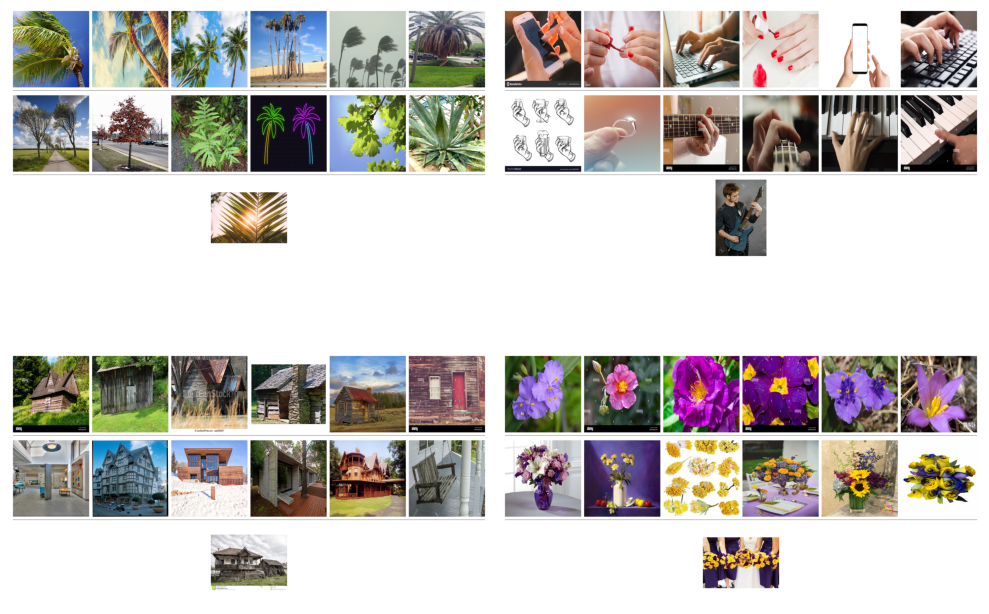

In [29]:
# Load images
image1 = Image.open("../debug_images/canvas_0789_query_B.png")
image2 = Image.open("../debug_images/canvas_0399_query_A.png")
image3 = Image.open("../debug_images/canvas_0159_query_B.png")
image4 = Image.open("../debug_images/canvas_0739_query_A.png")

# Create a 2x2 grid to display images
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

images = [image1, image2, image3, image4]

for ax, img in zip(axes.flatten(), images):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Commonsense Based Performance

In [30]:
print("\n=== COMMONSENSE CATEGORY PERFORMANCE ===")
common_sense_performance = {}
for category, model_results in common_sense_analysis.items():
    common_sense_performance[category] = {}
    for model, results in model_results.items():
        if results:
            common_sense_performance[category][model] = sum(results) / len(results)

common_sense_df = pd.DataFrame(common_sense_performance).T.fillna(0)
if not common_sense_df.empty:
    common_sense_df['avg_accuracy'] = common_sense_df.mean(axis=1)
    common_sense_df = common_sense_df.sort_values('avg_accuracy')
    print("Common Sense Category difficulty (lowest accuracy first):")

    # display(common_sense_df.round(3))
    display_left_aligned(common_sense_df.round(3))


=== COMMONSENSE CATEGORY PERFORMANCE ===
Common Sense Category difficulty (lowest accuracy first):


,cmr_gemma3_llama4,sdr_gpt41_deepseekr1,cvr_gpt41,cmr_gpt41_qwen3,cmr_gemma3_gemma3,sdr_gpt41_gpt41,cmr_gemma3_qwen3,cmr_qwen25_deepseekr1,cmr_qwen25_qwen3,sdr_gpt41_gptoss,cmr_llama4_qwen3,cmr_gemini20_gemini20,cmr_gpt41_gpt41,cmr_gpt41_llama4,cmr_gpt41_gemma3,cvr_gemini20,cmr_qwen25_llama4,cmr_llama4_deepseekr1,cvr_qwen25,cmr_qwen25_gemma3,sdr_gpt41_qwen3,sdr_gemini20_gemini20,cvr_gpt5,cmr_gpt41_deepseekr1,cmr_gemma3_deepseekr1,cmr_llava16_deepseekr1,cvr_gemma3,cmr_gpt41_gptoss,cmr_llava16_qwen3,cmr_llama4_gemma3,cvr_mistral3,cmr_llava16_llama4,sdr_gpt41_llama4,cmr_llava16_gemma3,cvr_gemini25,cmr_gpt5_gpt5,cmr_llama4_llama4,avg_accuracy
Color / Material / Shape,0.500000,0.607000,0.714000,0.571000,0.429000,0.536000,0.464000,0.607000,0.536000,0.679000,0.464000,0.607000,0.607000,0.429000,0.500000,0.679000,0.464000,0.464000,0.536000,0.429000,0.429000,0.500000,0.750000,0.607000,0.571000,0.393000,0.536000,0.607000,0.429000,0.536000,0.357000,0.286000,0.429000,0.250000,0.679000,0.607000,0.464000,0.520000
And / Or / Not,0.625000,0.500000,0.625000,0.625000,0.375000,0.750000,0.500000,0.375000,0.500000,0.375000,0.750000,0.500000,0.750000,0.500000,0.250000,0.625000,0.625000,0.625000,0.625000,0.250000,0.625000,0.625000,0.750000,0.500000,0.625000,0.625000,0.625000,0.750000,0.375000,0.500000,0.625000,0.500000,0.500000,0.375000,0.500000,0.625000,0.875000,0.561000
Unusual Observations,0.750000,0.500000,0.688000,0.500000,0.625000,0.562000,0.625000,0.688000,0.562000,0.312000,0.625000,0.625000,0.625000,0.562000,0.562000,0.750000,0.688000,0.625000,0.625000,0.562000,0.500000,0.500000,0.750000,0.562000,0.562000,0.375000,0.625000,0.438000,0.438000,0.500000,0.500000,0.375000,0.562000,0.375000,0.562000,0.562000,0.562000,0.562000
Functionality / Status / Affordance,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.800000,0.500000,0.600000,0.600000,0.500000,0.700000,0.600000,0.600000,0.600000,0.600000,0.700000,0.700000,0.500000,0.600000,0.800000,0.700000,0.700000,0.700000,0.600000,0.500000,0.700000,0.500000,0.500000,0.500000,0.600000,0.800000,0.700000,0.700000,0.800000,0.500000,0.643000
Taste / Nutrition / Food,0.625000,0.375000,0.625000,0.875000,0.625000,0.625000,0.625000,0.875000,0.750000,0.750000,0.375000,0.875000,0.750000,0.750000,0.625000,0.625000,0.625000,0.750000,0.625000,0.625000,0.500000,0.625000,0.625000,0.625000,0.875000,0.750000,0.750000,0.875000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.750000,0.625000,0.875000,0.676000
Anything else*,0.672000,0.645000,0.748000,0.745000,0.659000,0.759000,0.745000,0.697000,0.714000,0.728000,0.741000,0.734000,0.721000,0.714000,0.693000,0.752000,0.714000,0.700000,0.741000,0.672000,0.628000,0.655000,0.807000,0.721000,0.707000,0.662000,0.672000,0.762000,0.669000,0.645000,0.662000,0.679000,0.552000,0.641000,0.755000,0.769000,0.672000,0.701000
Relationship,0.750000,0.875000,0.750000,0.625000,0.875000,0.625000,0.875000,0.750000,0.750000,0.625000,0.750000,0.750000,0.750000,0.750000,0.625000,0.750000,0.625000,0.875000,0.750000,0.750000,0.500000,0.750000,0.750000,0.500000,0.875000,0.625000,0.750000,0.750000,0.500000,0.750000,0.625000,0.625000,0.500000,0.500000,0.750000,0.750000,0.750000,0.706000
Factual Knowledge,0.667000,0.667000,0.750000,0.667000,0.750000,0.833000,0.833000,0.750000,0.833000,0.583000,0.750000,0.750000,0.750000,0.750000,0.750000,0.833000,0.833000,0.750000,0.667000,0.750000,0.583000,0.667000,0.750000,0.750000,0.917000,0.750000,0.917000,0.583000,0.583000,0.583000,0.500000,0.667000,0.250000,0.667000,0.833000,0.667000,0.750000,0.712000
Meta Class,0.625000,0.625000,0.875000,0.875000,0.625000,0.750000,0.750000,0.625000,0.500000,0.625000,0.750000,0.875000,0.625000,0.625000,0.750000,0.875000,0.625000,0.750000,0.750000,0.625000,0.750000,0.625000,0.875000,0.750000,0.625000,0.750000,0.875000,0.750000,0.875000,0.750000,0.750000,0.750000,0.375000,0.625000,0.875000,0.750000,0.875000,0.723000
HOI,0.750000,0.833000,1.000000,0.833000,0.750000,0.833000,0.750000,0.833000,0.833000,0.750000,0.

## Common Sense Difficulty Analysis

In [31]:
print("\n=== COMMON SENSE DIFFICULTY ANALYSIS ===")
common_sense_difficulty = {}
for category, results in difficulty_by_common_sense.items():
    if results:
        success_rate = sum(results) / len(results)
        common_sense_difficulty[category] = {
            'success_rate': success_rate,
            'total_attempts': len(results),
            'difficulty_score': 1 - success_rate
        }

# Convert to DataFrame instead of manual printing
df = pd.DataFrame.from_dict(common_sense_difficulty, orient='index')
df = df.sort_values('success_rate')  # Sort by success rate (ascending = most difficult first)
df['success_rate_pct'] = (df['success_rate'] * 100).round(2)

print("Most difficult common sense categories:")
display_left_aligned(df[['success_rate_pct', 'total_attempts', 'difficulty_score']].rename(columns={
    'success_rate_pct': 'Success Rate (%)',
    'total_attempts': 'Total Attempts', 
    'difficulty_score': 'Difficulty Score'
}))


=== COMMON SENSE DIFFICULTY ANALYSIS ===
Most difficult common sense categories:


,Success Rate (%),Total Attempts,Difficulty Score
Color / Material / Shape,52.030000,1036,0.479730
And / Or / Not,56.080000,296,0.439189
Unusual Observations,56.250000,592,0.437500
Functionality / Status / Affordance,64.320000,370,0.356757
Taste / Nutrition / Food,67.570000,296,0.324324
Anything else*,70.140000,10730,0.298602
Relationship,70.610000,296,0.293919
Factual Knowledge,71.170000,444,0.288288
Meta Class,72.300000,296,0.277027
HOI,78.830000,444,0.211712


## Model Performance Visualization

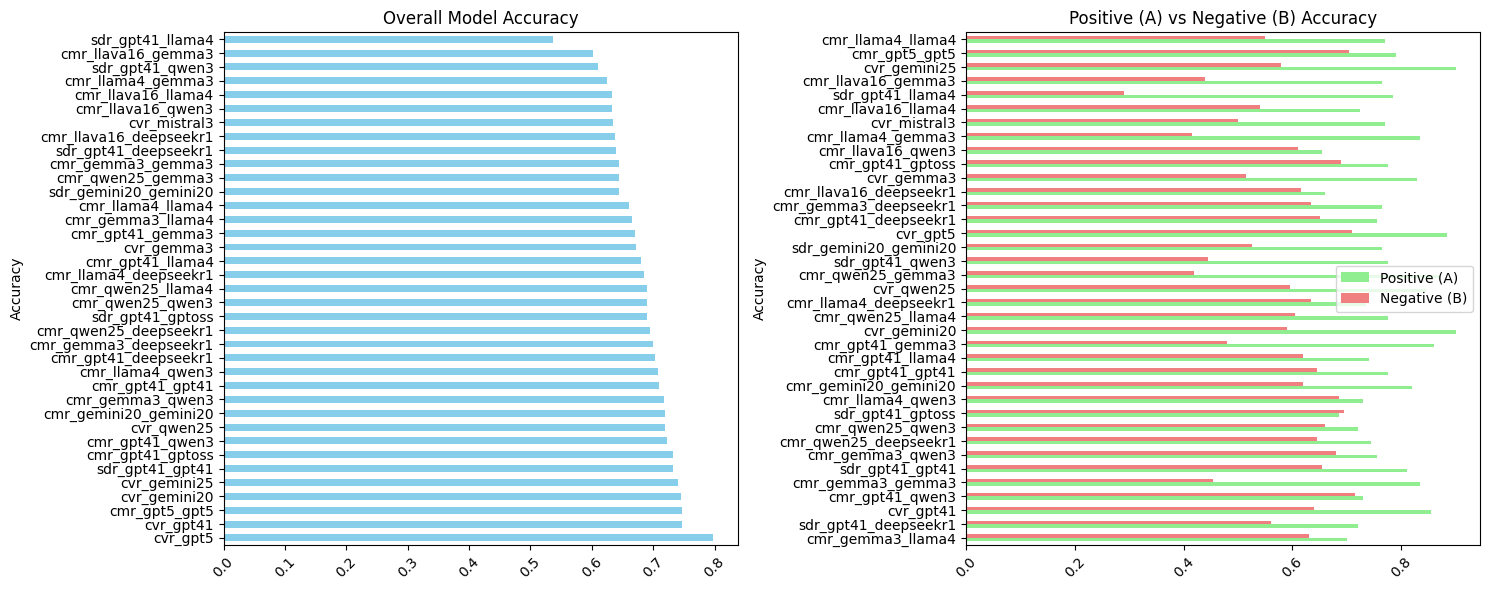

In [32]:
# Model Performance with A/B Breakdown
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Overall accuracy
df_performance['accuracy'].plot(kind='barh', ax=ax1, color='skyblue')
ax1.set_title('Overall Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', rotation=45)

# A vs B accuracy
pos_neg_plot_data = pos_neg_df[['A_accuracy', 'B_accuracy']]
pos_neg_plot_data.plot(kind='barh', ax=ax2, color=['lightgreen', 'lightcoral'])
ax2.set_title('Positive (A) vs Negative (B) Accuracy')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(['Positive (A)', 'Negative (B)'])

plt.tight_layout()
plt.show()

## Common Sense Category Heatmap

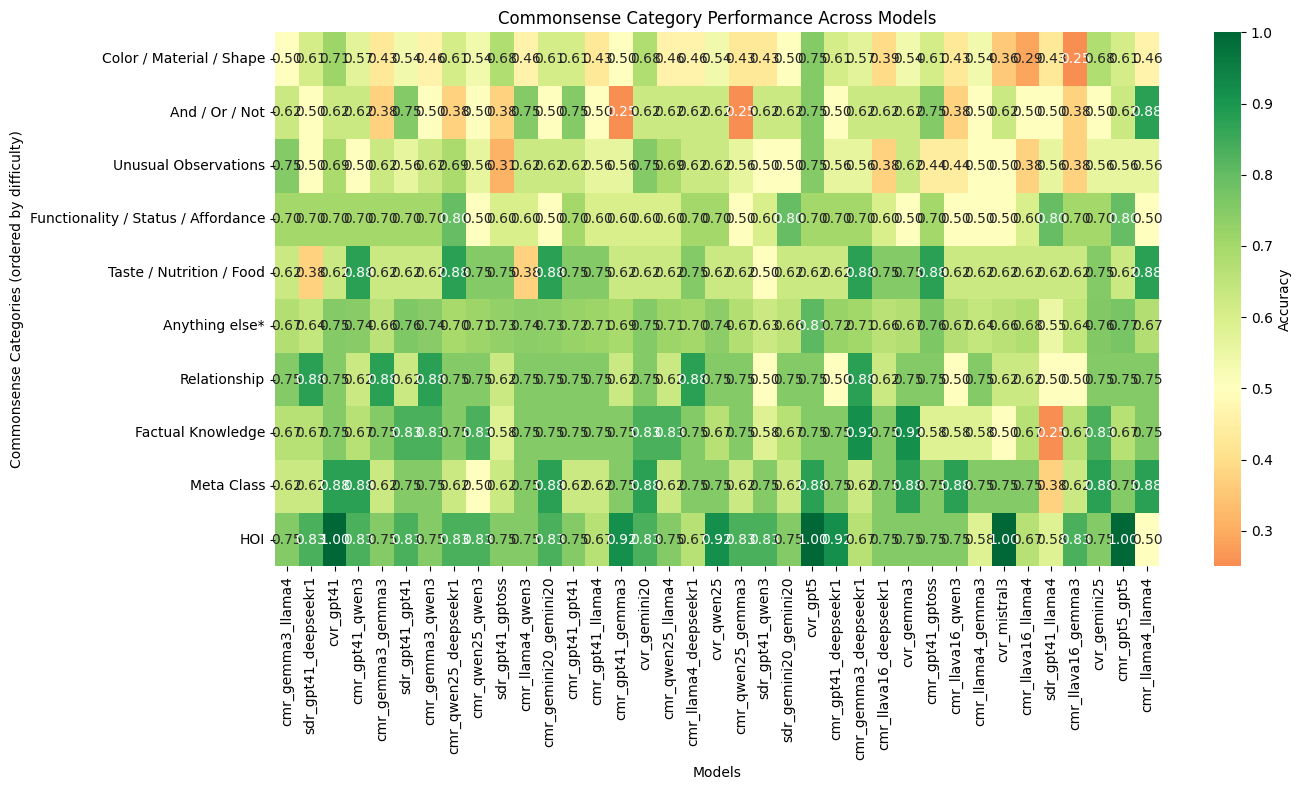

In [33]:
# Common Sense Category Heatmap
if not common_sense_df.empty and len(common_sense_df) > 1:
    plt.figure(figsize=(14, 8))
    sns.heatmap(common_sense_df.drop('avg_accuracy', axis=1), 
                annot=True, cmap='RdYlGn', center=0.5, fmt='.2f',
                cbar_kws={'label': 'Accuracy'})
    plt.title('Commonsense Category Performance Across Models')
    plt.ylabel('Commonsense Categories (ordered by difficulty)')
    plt.xlabel('Models')
    plt.tight_layout()
    plt.show()

## Answer Distribution Visualization

In [34]:
# Add this section after your model performance analysis

print("\n=== PARADIGM-BASED PERFORMANCE SUMMARY ===")

# Group models by paradigm
paradigm_groups = {
    'CVR': [],
    'CMR': [], 
    'SDR': []
}

# Categorize models by paradigm
for model_name in pos_neg_analysis.keys():
    if model_name.startswith('cvr_'):
        paradigm_groups['CVR'].append(model_name)
    elif model_name.startswith('cmr_'):
        paradigm_groups['CMR'].append(model_name)
    elif model_name.startswith('sdr_'):
        paradigm_groups['SDR'].append(model_name)

# Calculate averages for each paradigm
paradigm_summary = {}

for paradigm, models in paradigm_groups.items():
    if models:  # Only process if there are models in this paradigm
        total_a_correct = sum(pos_neg_analysis[model]['A_correct'] for model in models)
        total_a_attempts = sum(pos_neg_analysis[model]['A_total'] for model in models)
        total_b_correct = sum(pos_neg_analysis[model]['B_correct'] for model in models)
        total_b_attempts = sum(pos_neg_analysis[model]['B_total'] for model in models)
        
        avg_pos_acc = total_a_correct / total_a_attempts
        avg_neg_acc = total_b_correct / total_b_attempts
        avg_bias = avg_pos_acc - avg_neg_acc
        
        paradigm_summary[paradigm] = {
            'Avg Pos Acc (%)': round(avg_pos_acc * 100, 1),
            'Avg Neg Acc (%)': round(avg_neg_acc * 100, 1),
            'Avg Bias (%)': round(avg_bias * 100, 1),
            'Model Count': len(models)
        }

# Calculate overall averages
all_models = [model for models in paradigm_groups.values() for model in models]
total_a_correct_all = sum(pos_neg_analysis[model]['A_correct'] for model in all_models)
total_a_attempts_all = sum(pos_neg_analysis[model]['A_total'] for model in all_models)
total_b_correct_all = sum(pos_neg_analysis[model]['B_correct'] for model in all_models)
total_b_attempts_all = sum(pos_neg_analysis[model]['B_total'] for model in all_models)

overall_avg_pos = total_a_correct_all / total_a_attempts_all
overall_avg_neg = total_b_correct_all / total_b_attempts_all
overall_avg_bias = overall_avg_pos - overall_avg_neg

paradigm_summary['Overall'] = {
    'Avg Pos Acc (%)': round(overall_avg_pos * 100, 1),
    'Avg Neg Acc (%)': round(overall_avg_neg * 100, 1),
    'Avg Bias (%)': round(overall_avg_bias * 100, 1),
    'Model Count': len(all_models)
}

# Create DataFrame
paradigm_df = pd.DataFrame.from_dict(paradigm_summary, orient='index')
paradigm_df = paradigm_df[['Avg Pos Acc (%)', 'Avg Neg Acc (%)', 'Avg Bias (%)']]  # Reorder columns

print("Paradigm Performance Summary:")
# display_left_aligned(paradigm_df)

# Also print in a more table-like format similar to your image
print(f"\n{'Paradigm':<12} {'Avg Pos Acc (%)':<16} {'Avg Neg Acc (%)':<16} {'Avg Bias (%)':<12}")
print("-" * 60)
for paradigm, data in paradigm_summary.items():
    print(f"{paradigm:<12} {data['Avg Pos Acc (%)']:<16} {data['Avg Neg Acc (%)']:<16} {data['Avg Bias (%)']:<12}")


=== PARADIGM-BASED PERFORMANCE SUMMARY ===
Paradigm Performance Summary:

Paradigm     Avg Pos Acc (%)  Avg Neg Acc (%)  Avg Bias (%)
------------------------------------------------------------
CVR          85.5             59.0             26.5        
CMR          76.2             59.8             16.4        
SDR          75.7             52.8             22.8        
Overall      77.9             58.5             19.4        


## Bias Analysis Visualization

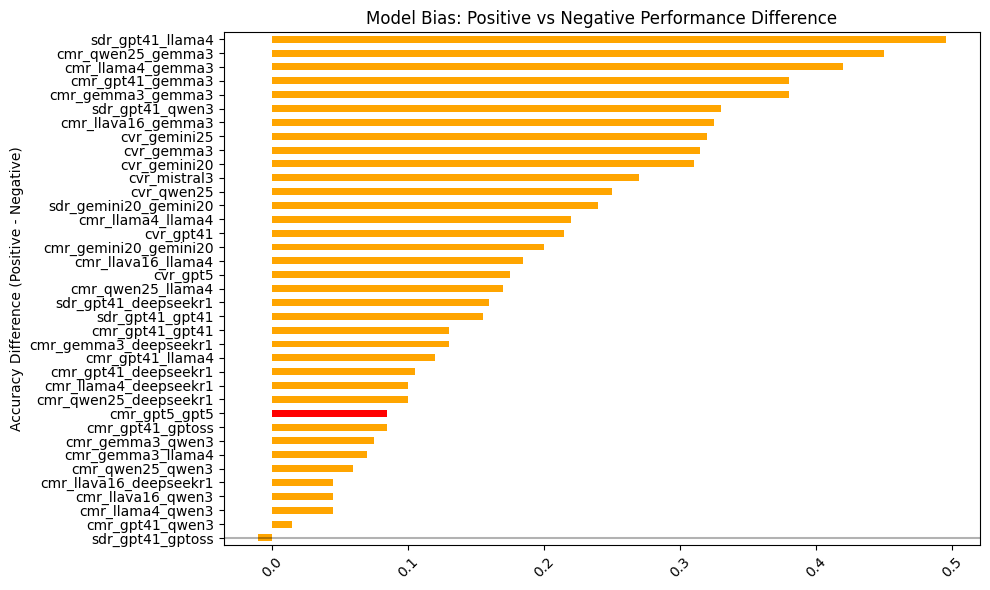

In [35]:
# Bias Analysis Visualization
if not pos_neg_df.empty:
    sorted_df = pos_neg_df.sort_values('pos_neg_diff')
    plt.figure(figsize=(10, 6))
    colors = ['red' if x < 0 else 'orange' for x in pos_neg_df['pos_neg_diff']]
    sorted_df['pos_neg_diff'].plot(kind='barh', color=colors)
    plt.title('Model Bias: Positive vs Negative Performance Difference')
    plt.ylabel('Accuracy Difference (Positive - Negative)')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Export Results

In [36]:
# Export enhanced results
enhanced_results = {
    'model_performance': model_performance,
    'pos_neg_analysis': dict(pos_neg_analysis),
    'common_sense_performance': common_sense_performance,
    'common_sense_difficulty': common_sense_difficulty,
    'common_sense_mapping': common_sense_mapping,
    'metadata_sample': dict(list(metadata.items())[:5])
}

with open('enhanced_analysis.json', 'w') as f:
    json.dump(enhanced_results, f, indent=2, default=str)

print("Enhanced analysis exported to enhanced_analysis.json")
print("All visualizations generated!")

Enhanced analysis exported to enhanced_analysis.json
All visualizations generated!
